**Instalación y Configuración de SQL Server en EC2 con Windows Server 2019 y Optimización de Almacenamiento RAID**

Crear la Instancia EC2



*   Accedemos a AWS Management Console y creamos una nueva instancia EC2, le asignamos el nombre "Windows" a la instancia.

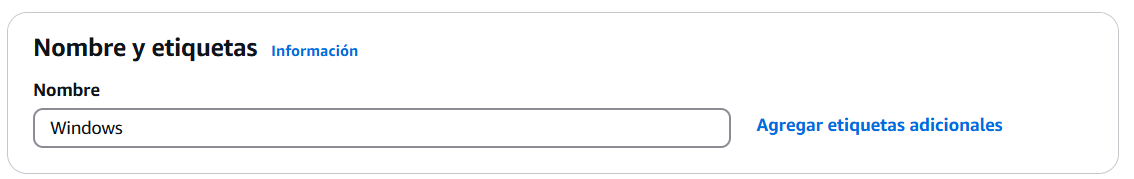





*   Seleccionamos la imagen Windows Server 2019 con SQL Server 2019 Base.

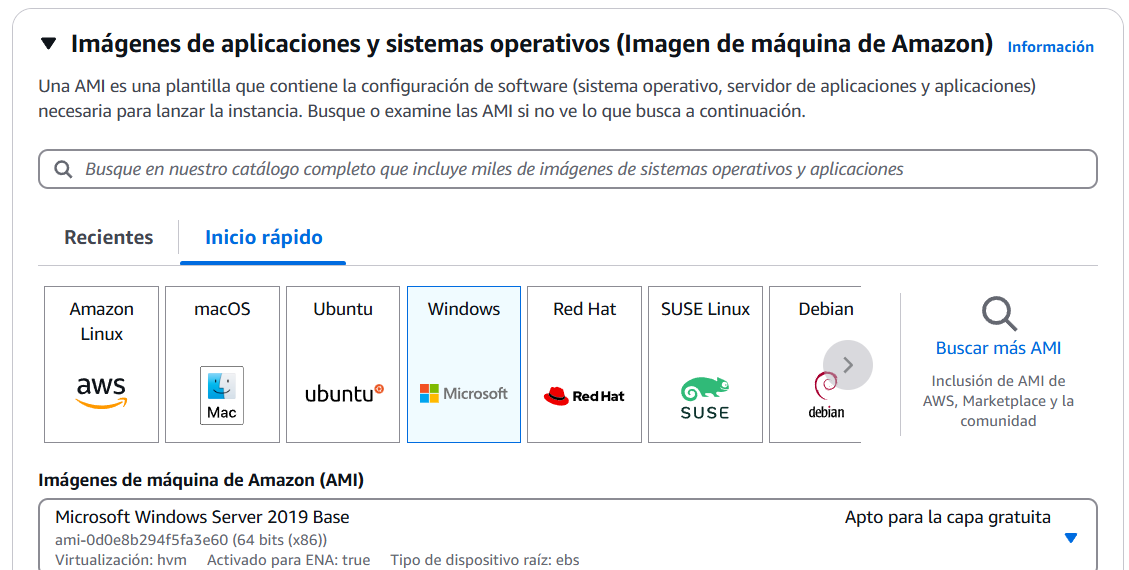





*   Elegimos el tipo de instancia t2.medium, que es el mínimo requerido para que la instancia funcione correctamente.

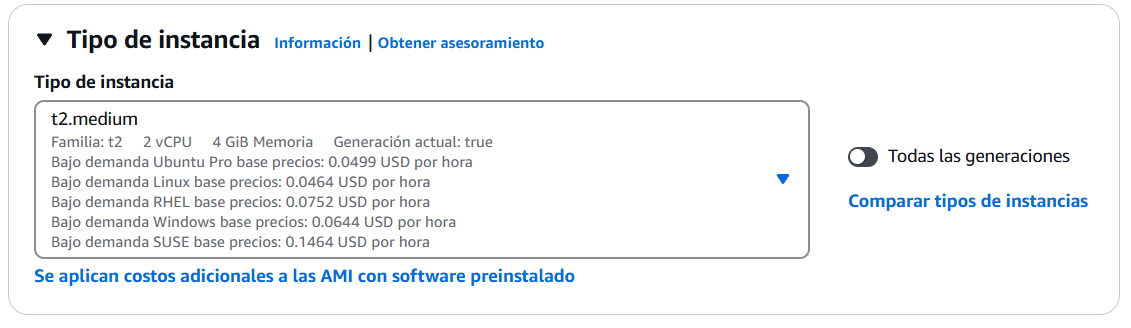







*   Creamos un par de llaves en formato .pem para
acceder de manera segura a la instancia.

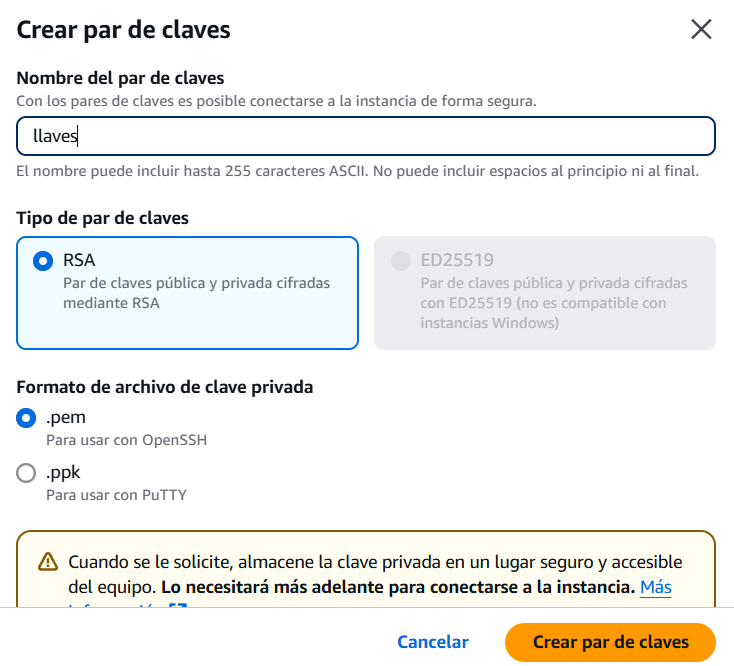



*   Establecemos un volumen raíz de 40 GB Y añadimos 11 volúmenes adicionales para poder configurar los RAID necesarios más adelante.
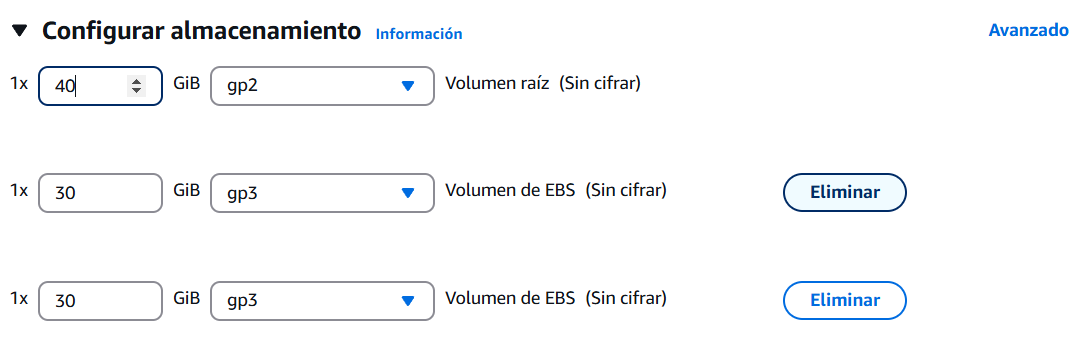


**Conectarse a la Instancia mediante RDP**



*   Seleccionamos la instancia EC2 creada en el panel de AWS, presionamos el botón Conectar y navegamos al apartado Cliente RDP, descargamos el archivo de Escritorio Remoto (.rdp) proporcionado.

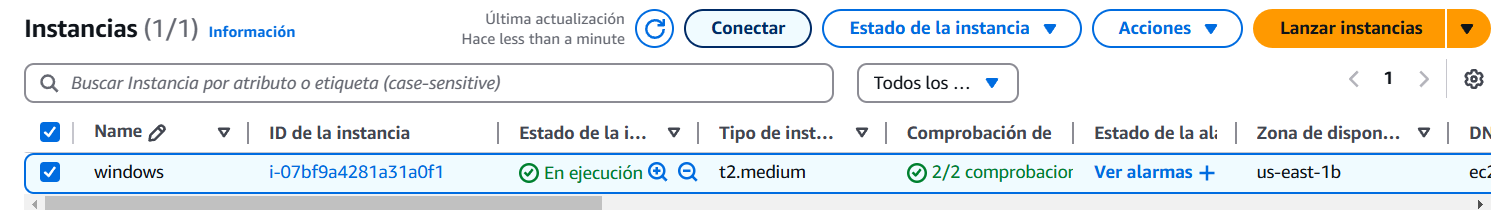

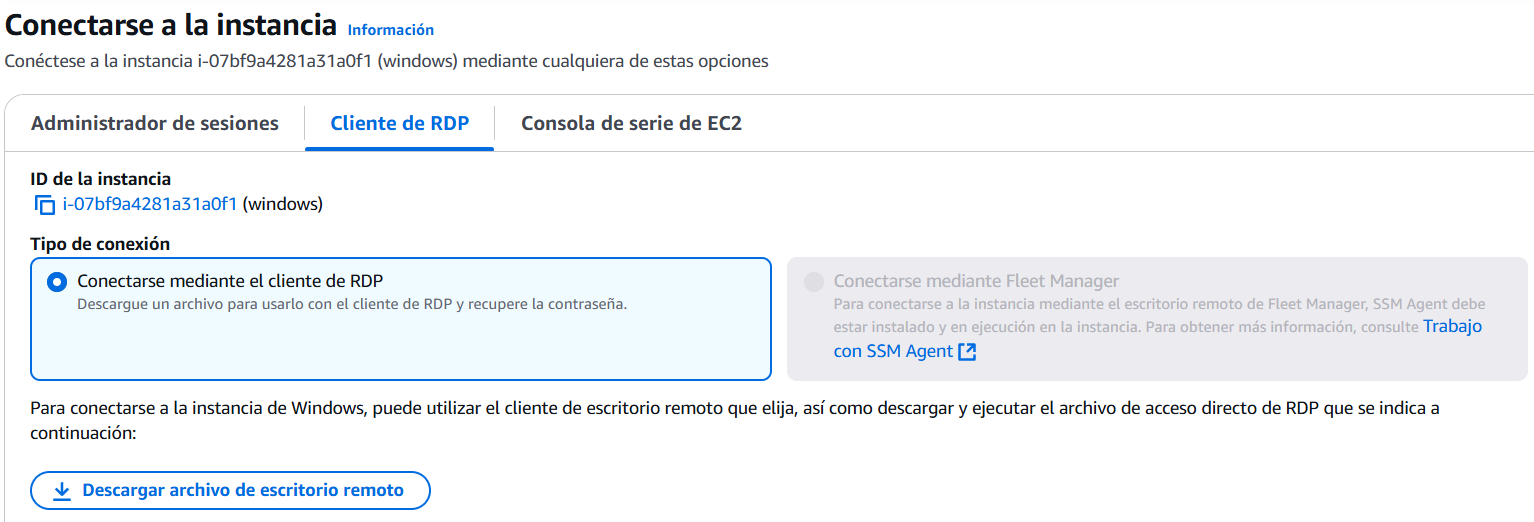



*   Utilizamos el par de llaves RSA creado anteriormente para descifrar la contraseña de administrador.
En la sección correspondiente, cargamos la llave .pem y copiamos la contraseña descifrada.

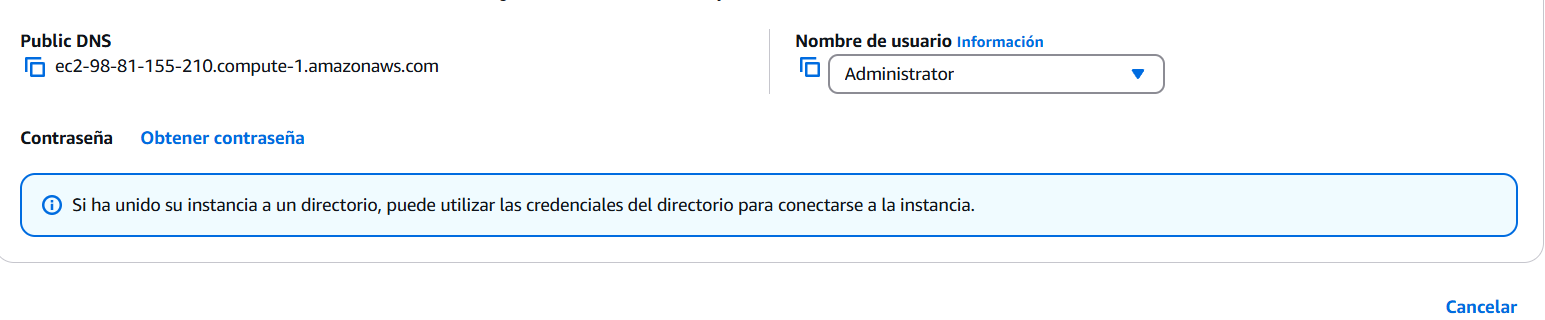
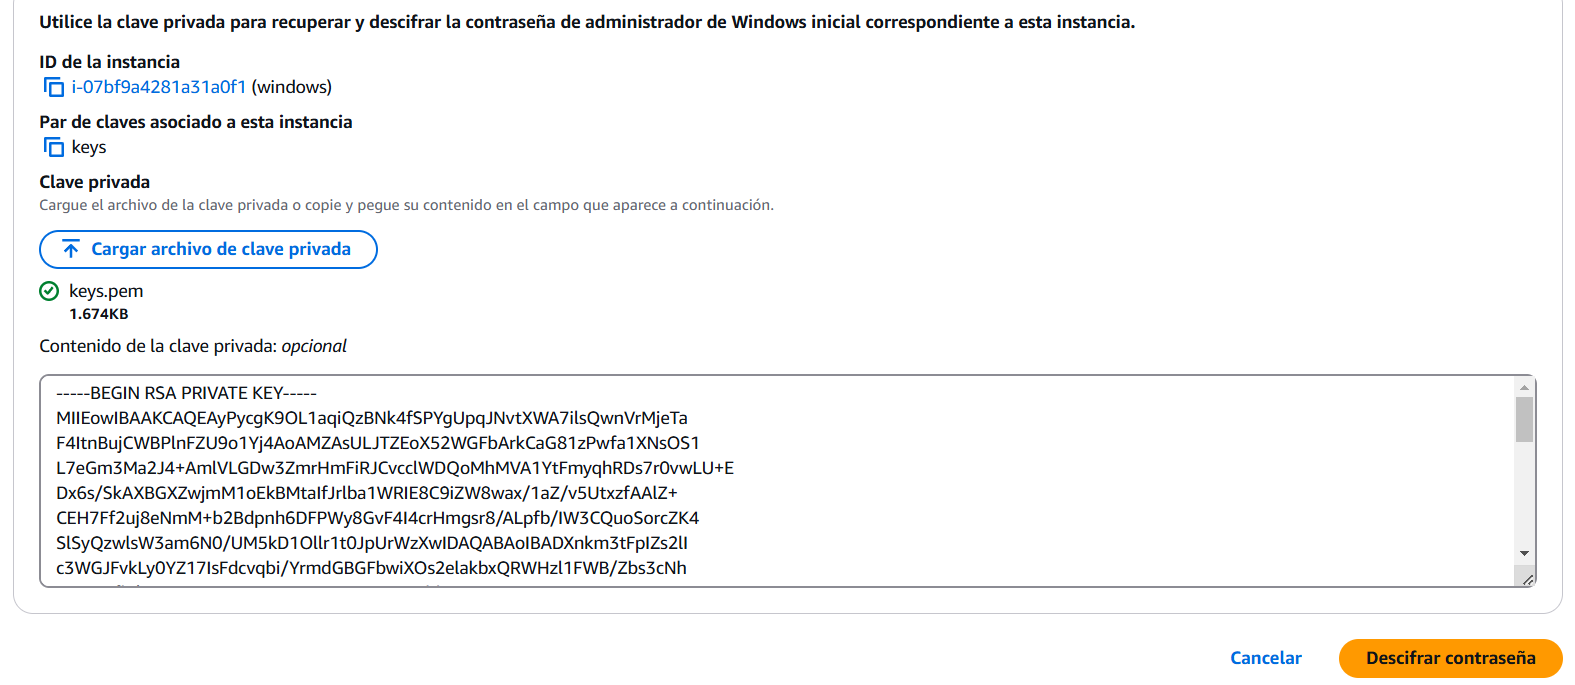


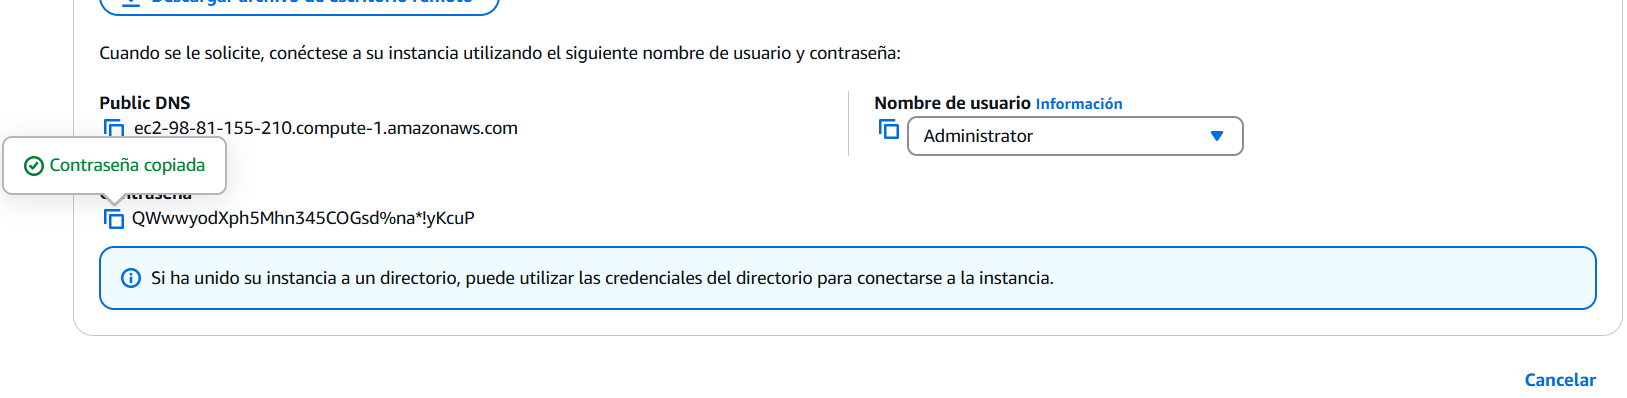



*   Abrimos el archivo .rdp descargado, lo que iniciará el cliente de Escritorio Remoto,
ingresamos la contraseña descifrada cuando se nos solicite(se debe aceptar cualquier ventana emergente).

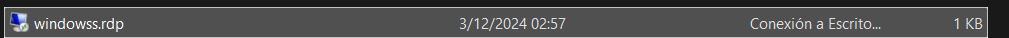

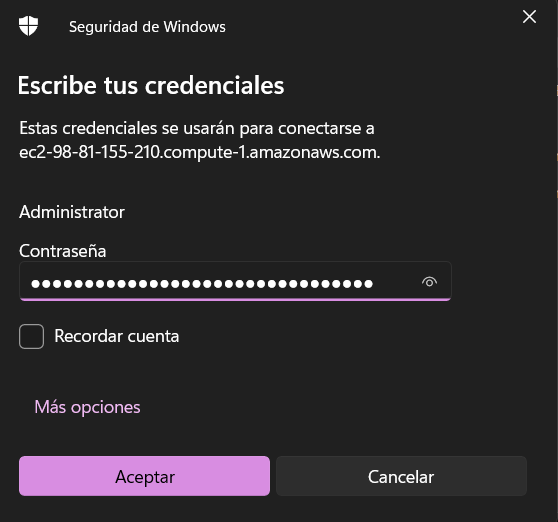

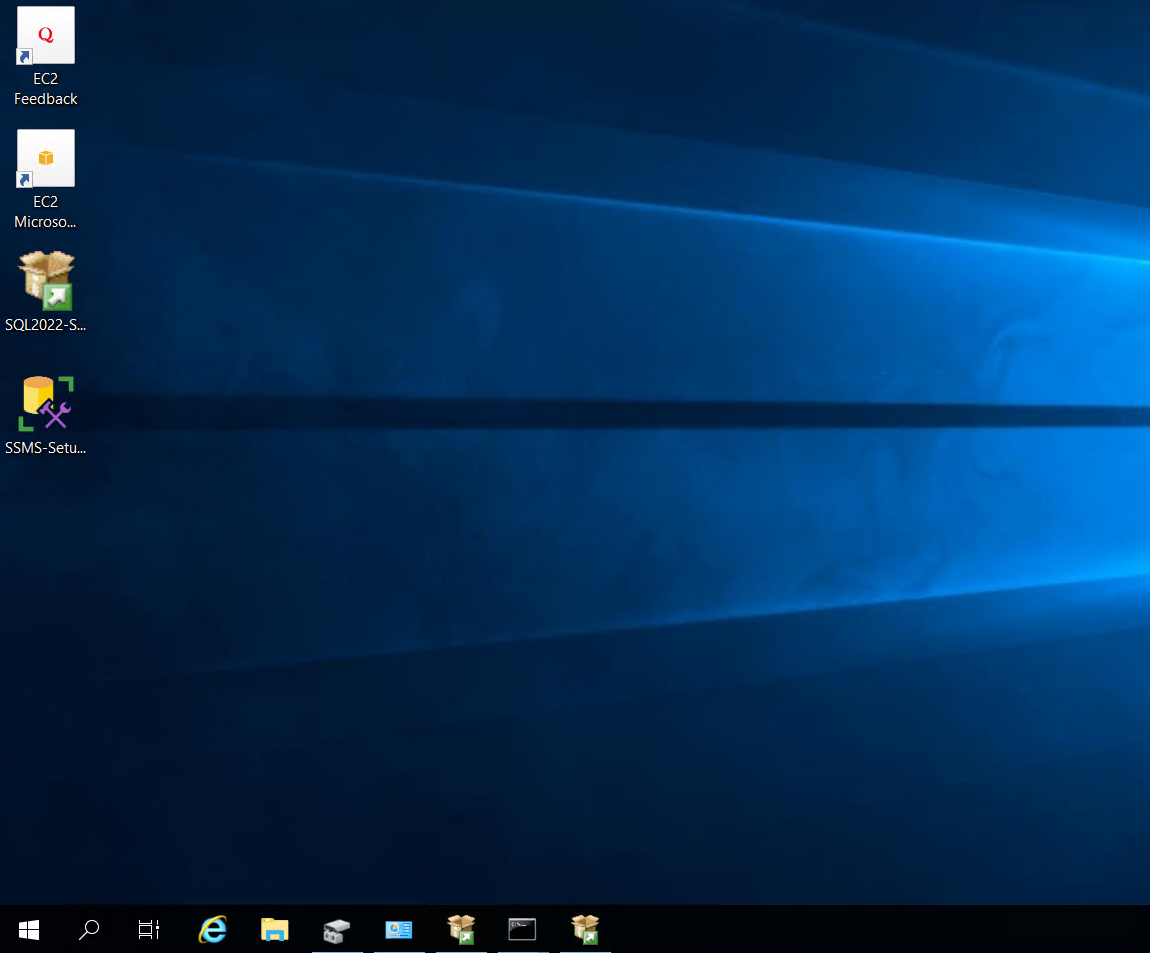

**Configurar los Discos**



*   Desde el entorno de Windows Server, ingresamos y seleccionando Manage.
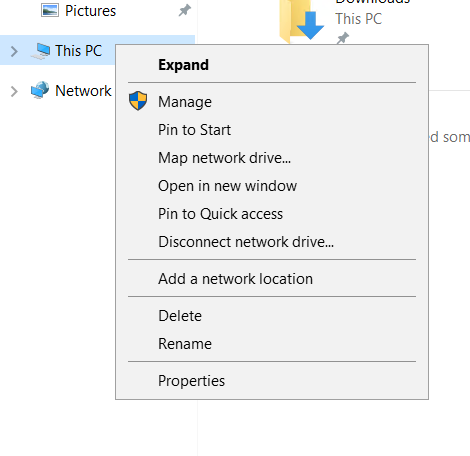



*   En el menú, seleccionamos File and Storage Services y luego navegamos a la sección Disks,
aquí se muestran todos los discos disponibles de la instancia, incluyendo los 11 discos adicionales, hacemos clic derecho sobre cada disco y seleccionamos la opción Bring Online para activar los discos.

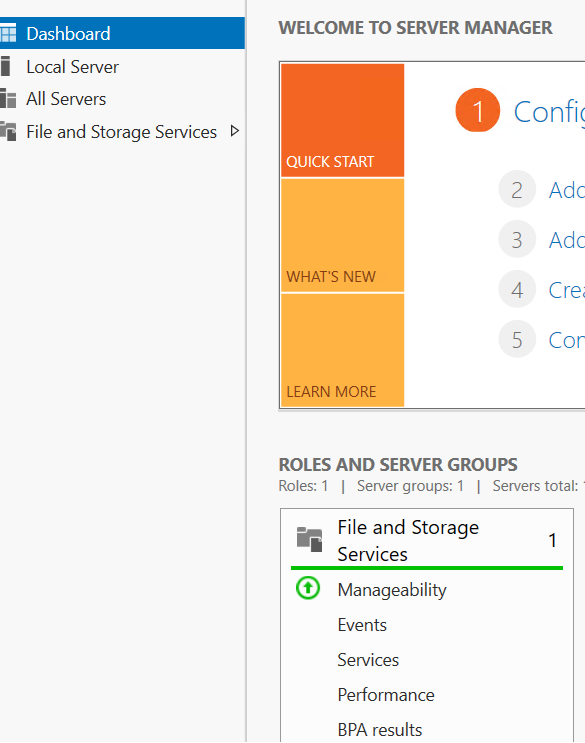

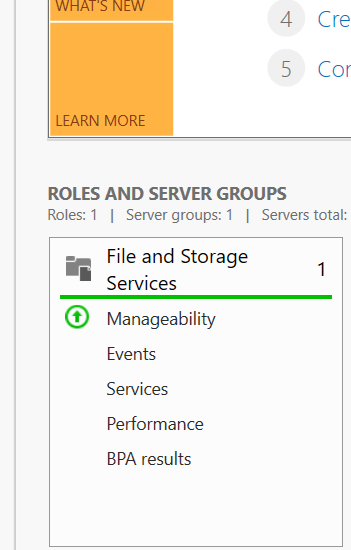






*   Ingresamos a Disk Management, seleccionamos cada disco que aparece como "no inicializado" y los inicializamos, luego Según la planificación configuramos:


  1.  RAID 5: Seleccionamos 3 discos para crear un RAID 5 y configurarlo como almacenamiento de backup.
  2. RAID 0: Usamos 2 discos para RAID 0, destinado a TempDB.
  3. RAID 10: Seleccionamos 4 discos para RAID 10, configurado para Data.
  4. RAID 1: Usamos los 2 discos restantes para RAID 1, dedicado a Log.

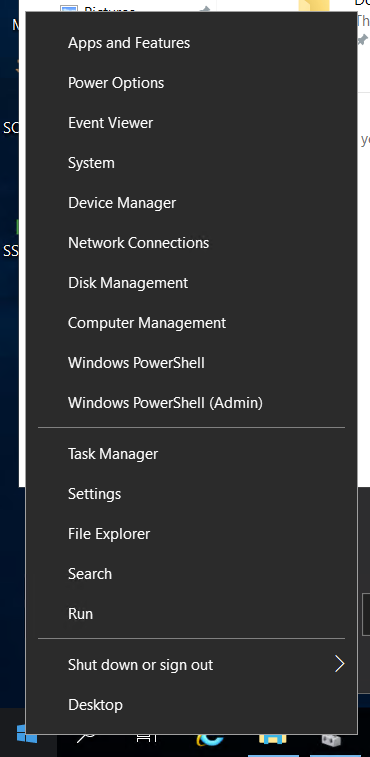

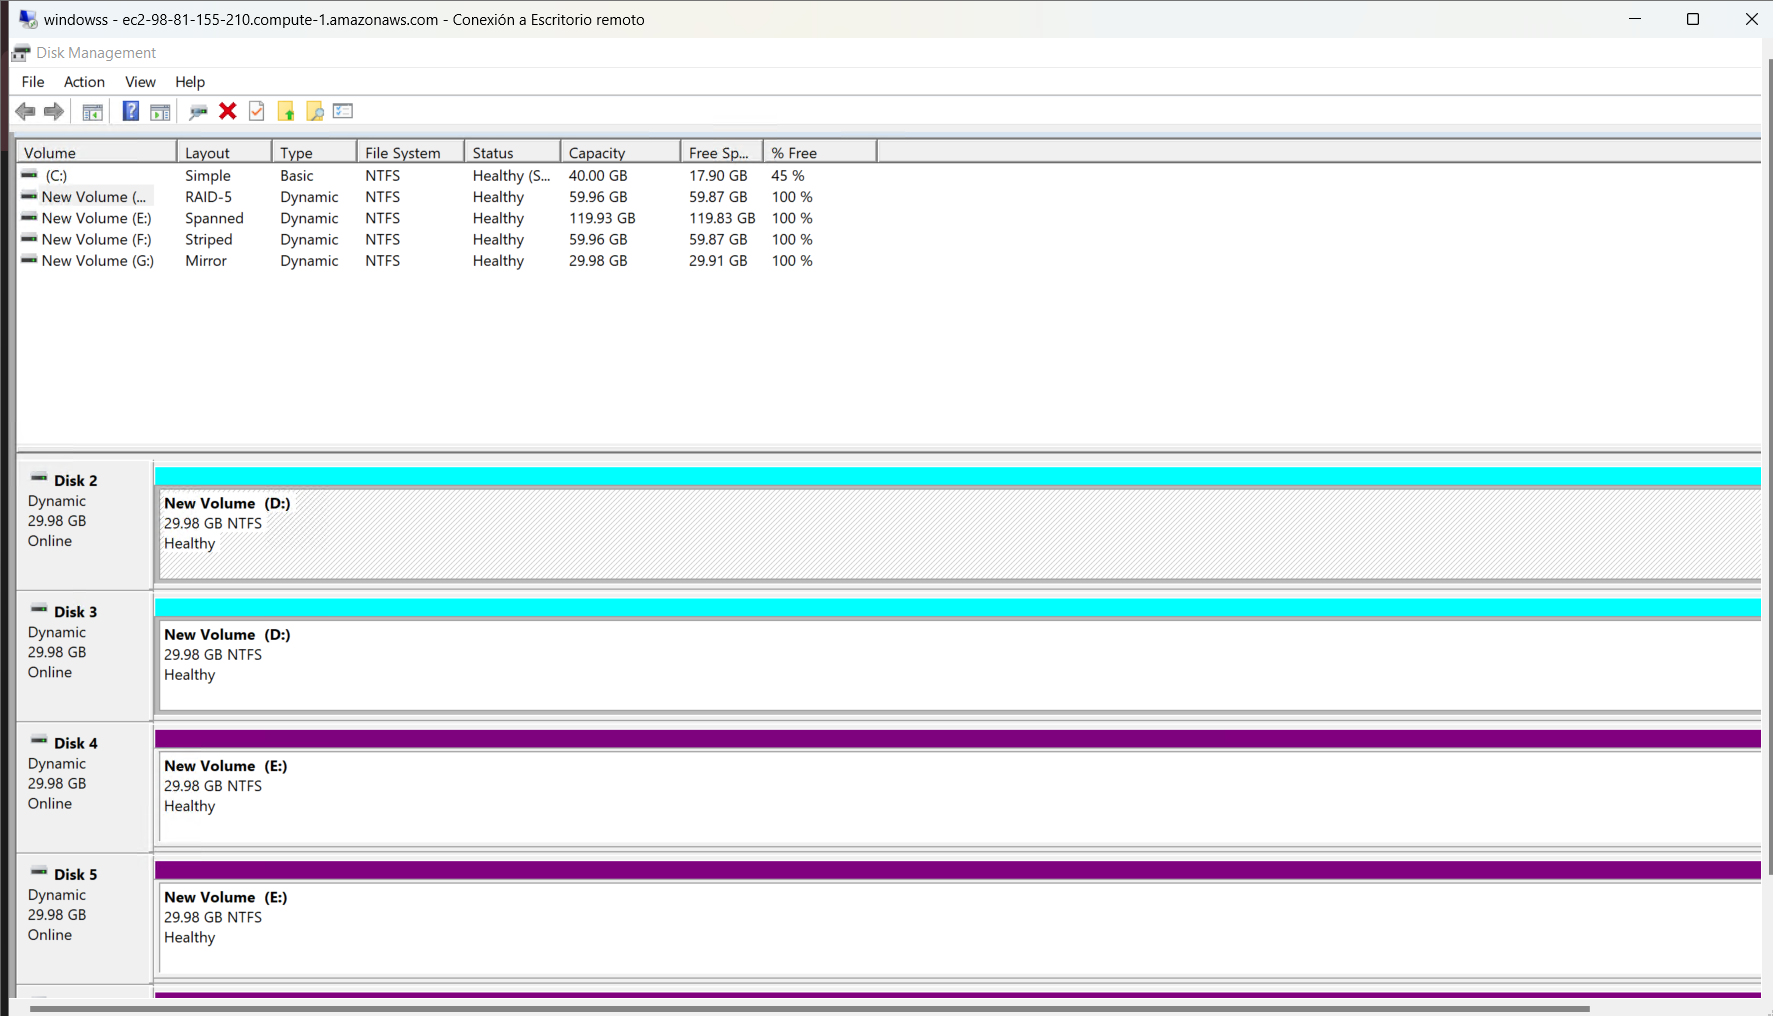



**Configuración de SQL Server**



*   Accedemos al sitio oficial de Microsoft SQL Server: [Descargar SQL Server](https://www.microsoft.com/es-es/sql-server/sql-server-downloads).

*   Seleccionamos la versión Developer (gratuita y para pruebas).
*   Descargamos el archivo de instalación y lo ejecutamos en la instancia.
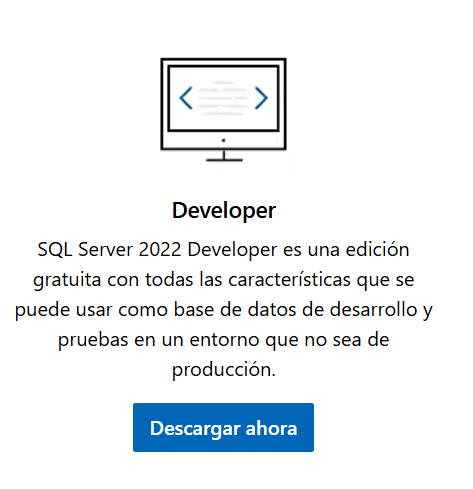

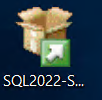



*   En el instalador, seleccionamos la opción de instalación Básica, proseguimos con la instalación y creamos una nueva instancia de SQL Server, definimos una contraseña segura para el usuario sa (Administrador del sistema).

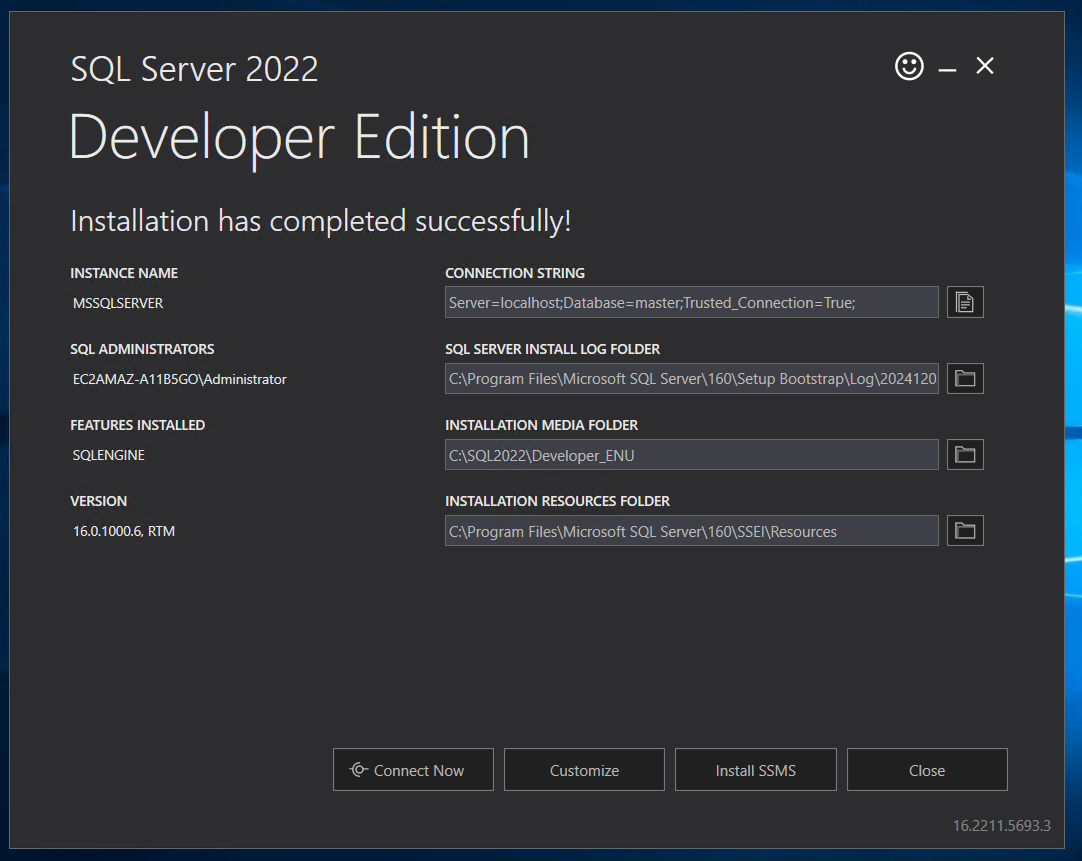

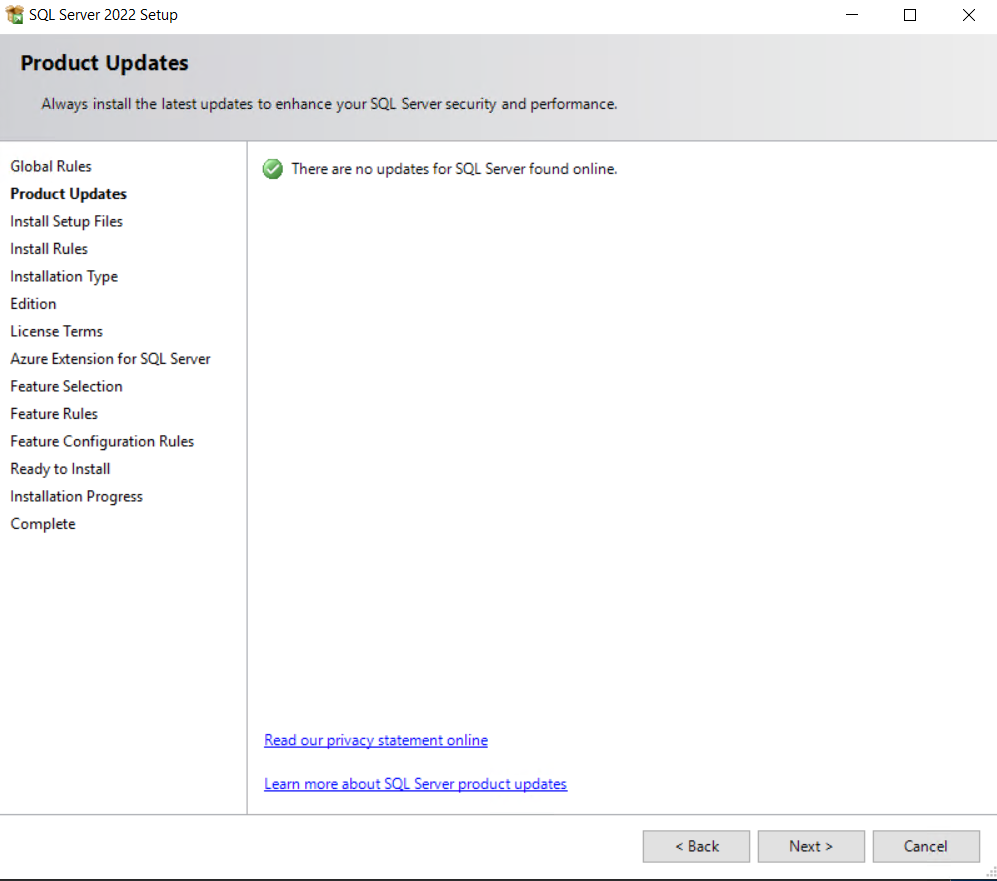





*   Antes de continuar con la configuración, otorgamos permisos de escritura en los directorios RAID. Ejecutamos el siguiente script en PowerShell:



```
takeown /f "D:\System Volume Information" /r /d y
icacls "D:\System Volume Information" /grant Administrators:(F) /t
----------------------------
takeown /f "E:\System Volume Information" /r /d y
icacls "E:\System Volume Information" /grant Administrators:(F) /t
----------------------------
takeown /f "G:\System Volume Information" /r /d y
icacls "G:\System Volume Information" /grant Administrators:(F) /t
```



*   Asignamos los directorios específicos según los RAID creados previamente:


1.   RAID 0: Ubicación para TempDB.
2. RAID 1: Ubicación para los Logs.
3. RAID 10: Ubicación para los Datos.
4. RAID 5: Ubicación para los Backups.



**Verificar el Funcionamiento**


*   Iniciamos sesión en SQL Server utilizando sqlcmd desde el CMD:


```
sqlcmd -S localhost\MSSQLSERVERR -U sa -P Sql@server10
```


*   Ejecutamos la siguiente consulta para visualizar las bases de datos disponibles:


```
SELECT name FROM sys.databases;
GO

```


*   Crear una Base de Datos y una Tabla de Prueba



```
-- Crear la base de datos TestDB
CREATE DATABASE TestDB;
GO

-- Usar la base de datos creada
USE TestDB;
GO

-- Crear una tabla llamada Personas
CREATE TABLE Personas (
    ID INT PRIMARY KEY IDENTITY(1,1),
    Nombre NVARCHAR(50),
    Edad INT
);
GO

-- Insertar registros de prueba en la tabla Personas
INSERT INTO Personas (Nombre, Edad) VALUES ('Juan', 30);
INSERT INTO Personas (Nombre, Edad) VALUES ('María', 25);
GO

```






